# Image alignment
Use the conda/image_mimic environment.

Python == 3.9.21
3.9.21 (main, Dec 11 2024, 16:35:24) [MSC v.1929 64 bit (AMD64)]

Image mimic using cv2
```
conda create -n image_mimic python=3.9 -y
conda activate image_mimic
conda install -c conda-forge opencv -y
python -c "import cv2; print(cv2.__version__)"

conda install -c defaults mkl mkl-service mkl_fft mkl_random --force-reinstall

"import cv2; print(cv2.__version__)"
# 4.10.0

conda install -c conda-forge matplotlib seaborn pandas scikit-image plotly -y

```


In [1]:
# python version
import sys
print("Python version: " + sys.version)
print("Version info: ", end="")
print(sys.version_info)

import cv2
print("cv2 version: " + cv2.__version__)


Python version: 3.9.21 (main, Dec 11 2024, 16:35:24) [MSC v.1929 64 bit (AMD64)]
Version info: sys.version_info(major=3, minor=9, micro=21, releaselevel='final', serial=0)
cv2 version: 4.10.0


In [ ]:
## import packages
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import math
import gc


def myplots(img_ls, title_ls=None):
    if title_ls is None:
        title_ls = [f'Image {i+1}' for i in range(len(img_ls))]
    nrow = math.ceil(len(img_ls) / 3)
    ncol = 3 if len(img_ls) > 3 else len(img_ls)

    fig, ax = plt.subplots(nrow, ncol, figsize=(20, 10))
    for i in range(len(img_ls)):
        ax[i].imshow(img_ls[i])
        ax[i].set_title(title_ls[i])
        ax[i].axis('off')
        
    plt.tight_layout()
    plt.show()

## version 0.3
Fix the length/width ratio before image processing

In [368]:
import cv2
import numpy as np
import gc

def white_balance_lab(img):
    # in-place white balance on a BGR image using the LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    avg_a = np.mean(A)
    avg_b = np.mean(B)
    factor = (L / 255.0) * 1.1
    A = (A - (avg_a - 128) * factor).clip(0, 255).astype(np.uint8)
    B = (B - (avg_b - 128) * factor).clip(0, 255).astype(np.uint8)
    lab = cv2.merge((L, A, B))
    img[:] = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return img

def get_scale_rotation(H):
    """Decompose homography matrix into scale and rotation components"""
    # Extract rotation matrix using SVD decomposition
    R = H[:2, :2]
    U, S, Vt = np.linalg.svd(R)
    R = U @ Vt
    
    # Calculate scale factors
    det = np.linalg.det(R)
    scale_x = S[0] / det
    scale_y = S[1] / det
    
    # Calculate rotation angle
    rotation_rad = np.arctan2(R[1,0], R[0,0])
    return scale_x, scale_y, np.degrees(rotation_rad)

def align_images_enhanced(path1, path2, ransacReprojThreshold=5.0, drawPlot=False):
    # 1. Load and resize both images to the same dimensions
    img1 = cv2.imread(path1, cv2.IMREAD_COLOR)
    img2 = cv2.imread(path2, cv2.IMREAD_COLOR)

    # 2. Scale normalization using original dimensions
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    scale_factor = min(h1/h2, w1/w2)
    if scale_factor > 1: # if img1 is larger
        img1 = cv2.resize(img1, (int(w1/scale_factor), int(h1/scale_factor)), 
                          interpolation=cv2.INTER_AREA)
    else:
        img2 = cv2.resize(img2, (int(w2/scale_factor), int(h2/scale_factor)), 
                          interpolation=cv2.INTER_AREA)

    # 3. White balance and convert to grayscale
    white_balance_lab(img1)
    white_balance_lab(img2)
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    del img1, img2
    gc.collect()
    # myplots([gray1, gray2])

    # 4. Detect SIFT features
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None) # get keypoints and descriptors
    kp2, des2 = sift.detectAndCompute(gray2, None)
    # print(np.array(kp1).shape, np.array(kp2).shape)

    # orb = cv2.ORB_create(nfeatures=2000)
    # kp1, des1 = orb.detectAndCompute(gray1, None) # get keypoints and descriptors
    # kp2, des2 = orb.detectAndCompute(gray2, None)
    # print(np.array(kp1).shape, np.array(kp2).shape)

    # akaze = cv2.AKAZE_create() # Feature detection with AKAZE
    # kp1, des1 = akaze.detectAndCompute(gray1, None) # get keypoints and descriptors
    # kp2, des2 = akaze.detectAndCompute(gray2, None)
    # print(np.array(kp1).shape, np.array(kp2).shape)

    # # Feature matching
    # matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # matches = matcher.match(des1, des2)
    # 
    # # Sort matches by distance and keep top 15%
    # matches = sorted(matches, key=lambda x: x.distance)
    # keep = int(len(matches) * 0.15)
    # good_matches = matches[:keep]

    # 5. Match features with FLANN and apply Lowe's ratio test
    cv2.setRNGSeed(42)
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(des1, des2, k=2)
    good = [m for m, n in matches if m.distance < 0.7 * n.distance]
    if len(good) < 50:
        # If without enough good matches, select top 15%
        matches = flann.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)
        keep = max(200, int(len(matches) * 0.15))
        good = matches[:keep]
    # print(len(good))

    # 6. Homography estimation with RANSAC
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=ransacReprojThreshold)
    # print(get_scale_rotation(H))

    # 7. Geometric parameter extraction
    scale_x, scale_y, angle = get_scale_rotation(H)
    tx = H[0,2] if H.shape == (3,3) else 0
    ty = H[1,2] if H.shape == (3,3) else 0

    # 8. Apply transformation matrix
    h, w = gray2.shape
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    # M[0,2] += tx # do not translation in output
    # M[1,2] += ty
    aligned = cv2.warpAffine(gray2, M, (w, h),
                                flags=cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_REPLICATE)
    
    if drawPlot:
        print(myplots([gray1, gray2, aligned]))
    
    # 9. Cleanup
    del gray1, gray2, kp1, kp2, des1, des2, matches
    gc.collect()
    
    return aligned, {
        'rotation_angle': angle,
        'scale_x': scale_x,
        'scale_y': scale_y,
        'translation_x': tx,
        'translation_y': ty,
        'homography_matrix': H
    }


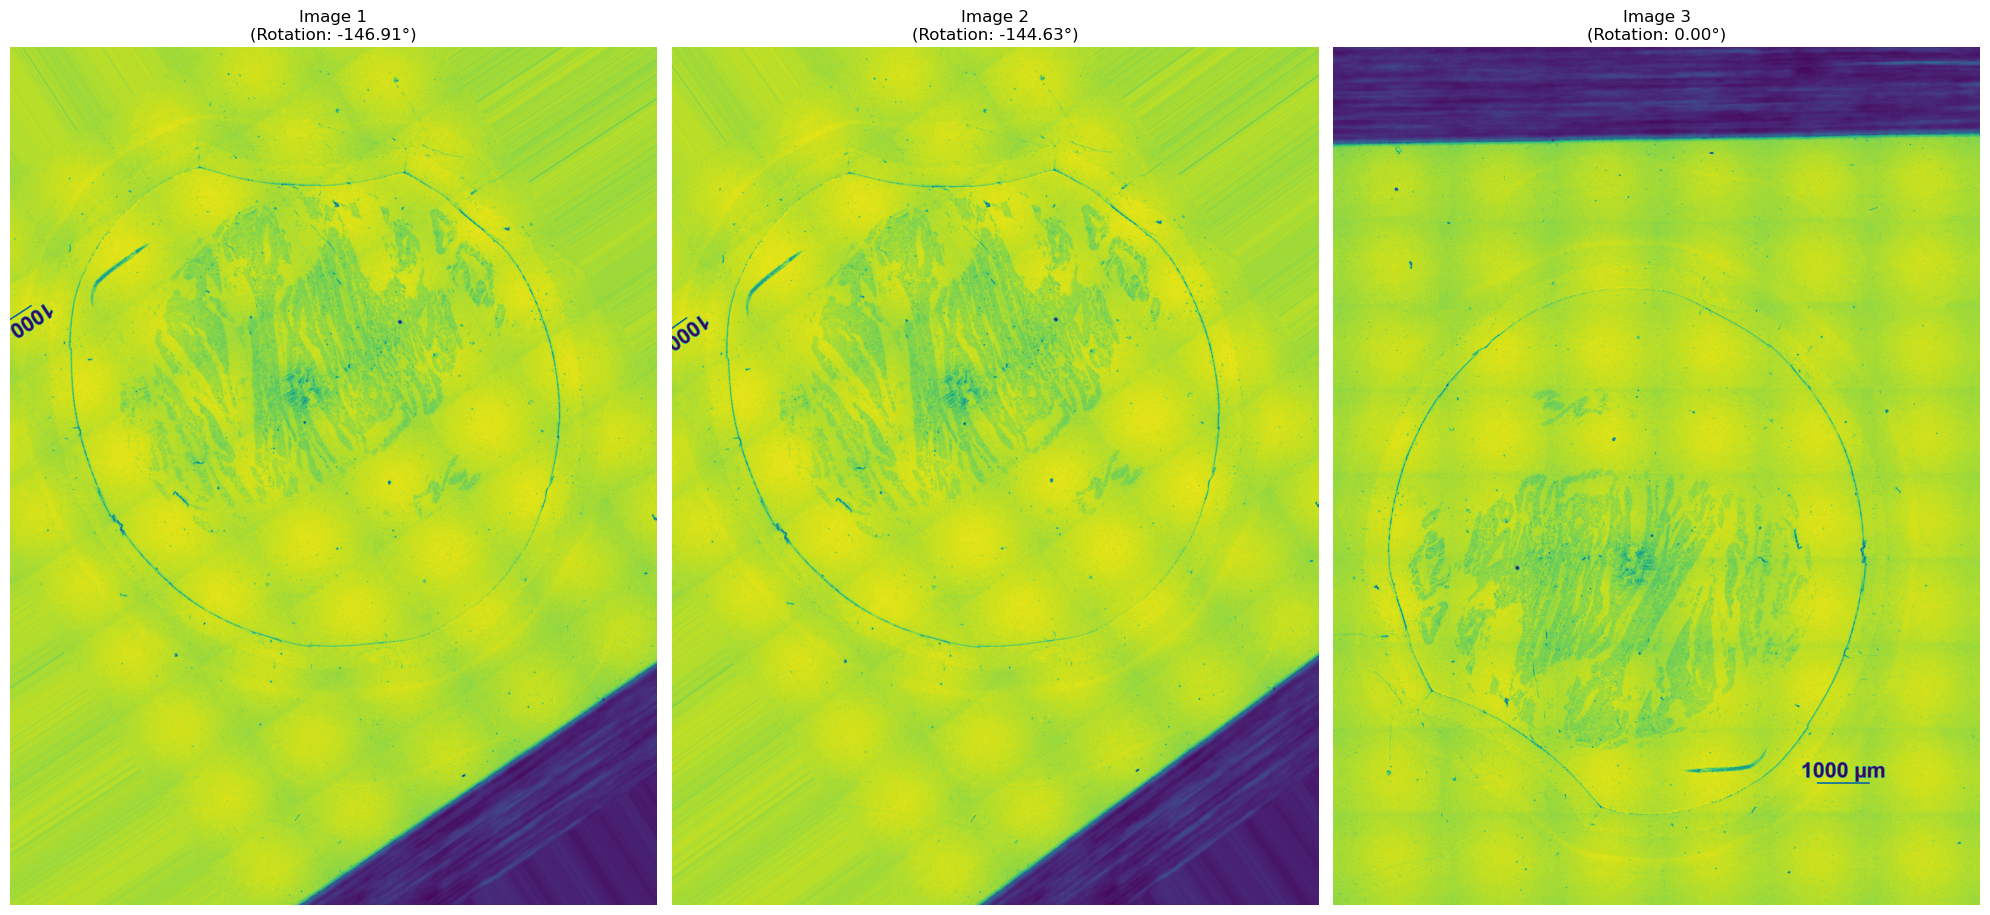

In [369]:
from pprint import pprint

# try real data
path1 = "20250527.images/20250526_SlideNo62_56X_beforeExp_E11.tif"
path2 = "20250527.images/20250526_SlideNo63_56X_beforeExp_E11.tif"
path3 = "20250527.images/20250526_SlideNo63_56X_afterExp_E11.tif"

# # image3_d, params_d = align_images_enhanced(path3, path3)
# plt.imshow(image3_d),plt.show()
# pprint(params_d)


image3_a, params_a = align_images_enhanced(path1, path3, ransacReprojThreshold=20.0)
image3_b, params_b = align_images_enhanced(path2, path3, ransacReprojThreshold=10.0)
image3_c, params_c = align_images_enhanced(path3, path3)

img_ls = [image3_a, image3_b, image3_c]
params_ls = [params_a, params_b, params_c]
title_ls = [f"Image {i+1}\n(Rotation: {params_ls[i]['rotation_angle']:.2f}°)" for i in range(len(img_ls))]
myplots(img_ls, title_ls=title_ls)
